<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/4_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Continuity


> Samples are needed for sequence models and transformer models for input


😈 **Task 1:** How does a basic MLP differ from models like RNNs or ARIMA when used for time series forecasting?

😈 **Question 1:** What challenges might arise when feeding sequences into a feedforward model like an MLP?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf




In [2]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Download the .pkl files from drive

In [5]:
import pickle
import numpy as np

# Define the path to multivariate .pkl files
base_path = "/content/drive/MyDrive/timeseries_datanew"

# Load multivariate training and test sets
with open(f"{base_path}/X_train_multi.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open(f"{base_path}/X_test_multi.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open(f"{base_path}/y_train_multi.pkl", "rb") as f:
    y_train_full = pickle.load(f)

with open(f"{base_path}/y_test_multi.pkl", "rb") as f:
    y_test_full = pickle.load(f)

print("Loaded multivariate data")
print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test_full shape:  {X_test_full.shape}")
print(f"y_test_full shape:  {y_test_full.shape}")

# Task 1: Use only O3 as input and target
X_train = X_train_full[:, :, 1].astype(np.float32)
X_test  = X_test_full[:, :, 1].astype(np.float32)
y_train = y_train_full[:, :, 1].astype(np.float32)
y_test  = y_test_full[:, :, 1].astype(np.float32)

# Reshape to add feature dimension (needed for MLP input)
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]
y_train = y_train[..., np.newaxis]
y_test  = y_test[..., np.newaxis]

print("O₃-only shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")


Loaded multivariate data
X_train_full shape: (95970, 336, 2)
y_train_full shape: (95970, 96, 2)
X_test_full shape:  (41131, 336, 2)
y_test_full shape:  (41131, 96, 2)
O₃-only shapes:
X_train: (95970, 336, 1), y_train: (95970, 96, 1)
X_test:  (41131, 336, 1),  y_test:  (41131, 96, 1)


### Forecasting with Simple Neural Network: MLP

> The below snippet uses tensorflow to create a simple

😈 **Task 2:** Try changing the number of input lags used. How does it affect forecasting accuracy?

😈 **Task 3:** Compare results using `no2` vs `o3` as the target variable.


The below cell has sample hyperparameters and activation, loss functions, Modify these values for experimentation


😈 **Task 4:** Modify the activation function to `tanh` or `selu`. How does training performance change?

😈 **Task 5:** Try different optimizers (e.g., SGD, RMSProp) and compare their impact on convergence.

😈 **Question 2:** Why might ReLU not be ideal for all types of time series data?

In [ ]:
## Remember the checkpoints made available are trained with below hyper params
# If changed you will have to retrain loading appropriate inputs like eg. loss
mlp_hidden_units = [64, 32]
mlp_epochs = 5
mlp_batch_size = 16
activation_fn='relu'
mlp_optim = 'adam'
mlp_loss = 'mse'

### Load the checkpoint

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
from checkpoint


MSE TEST 112.658


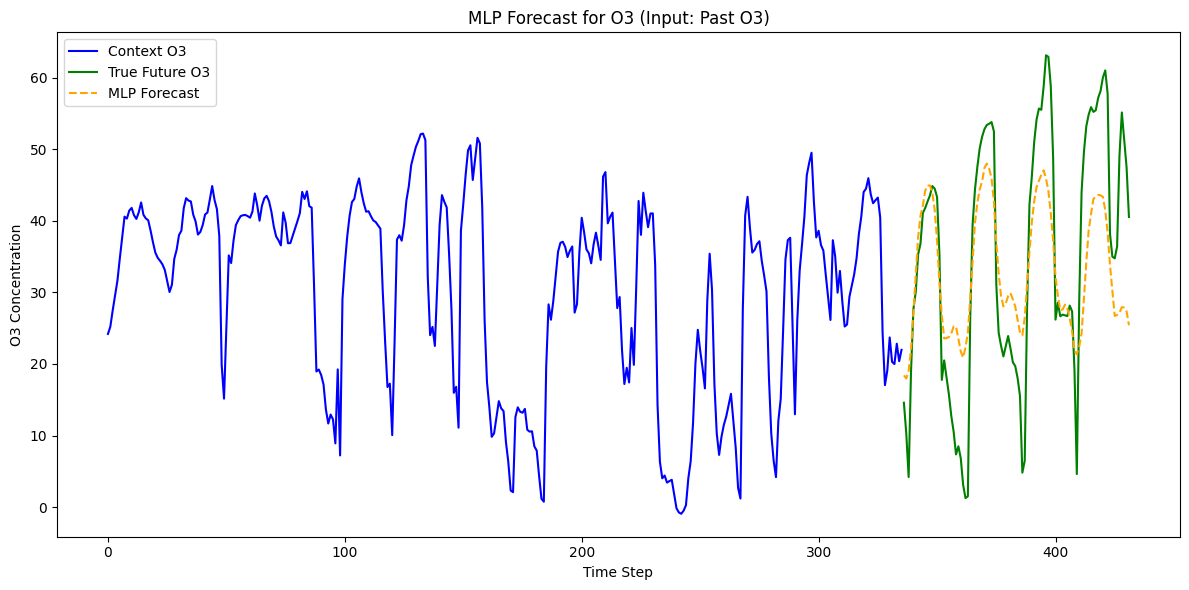

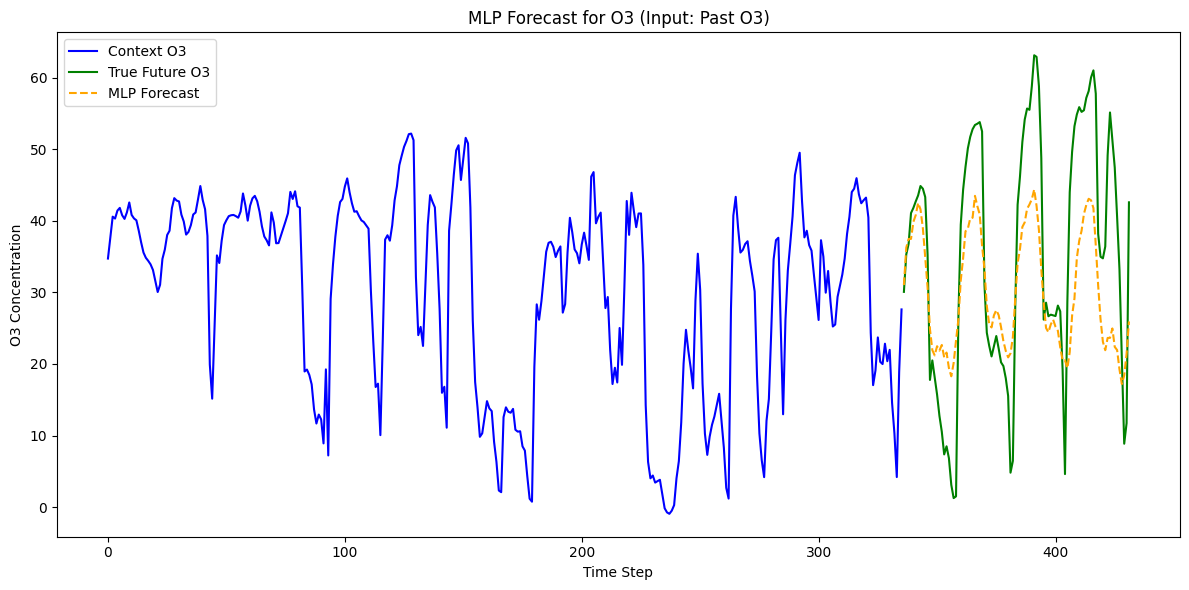

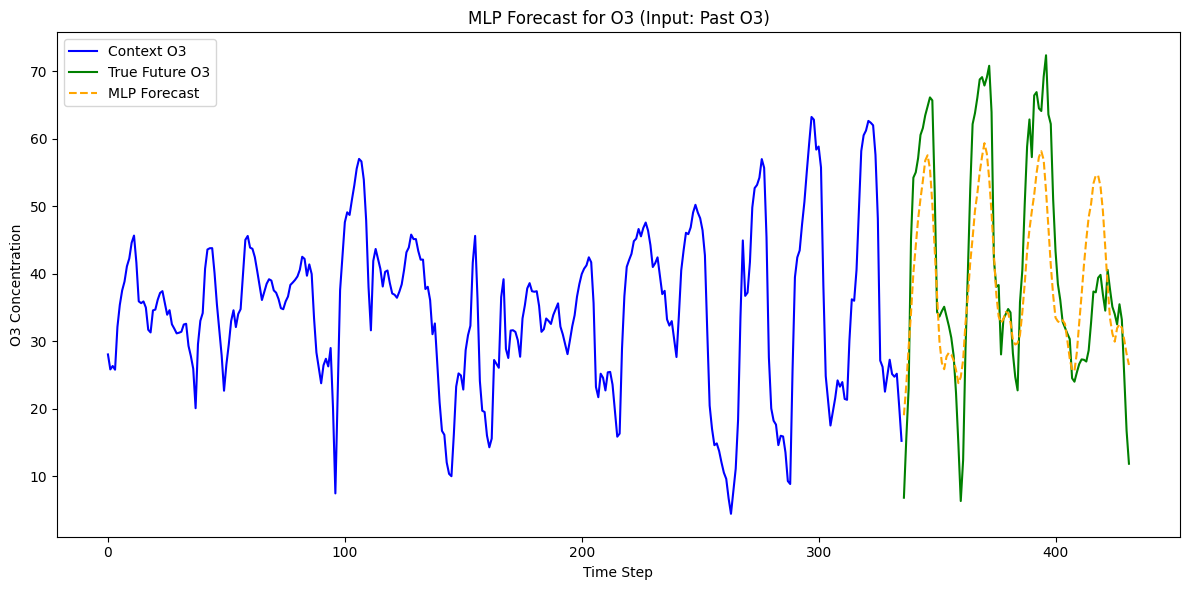

In [6]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from google.colab import drive

# mount Drive so we can read/save data
drive.mount("/content/drive")

# Settings for forecasting
context_window = 336           # how many past time steps the model sees
prediction_horizon = 96        # how many time steps forecast
model_id = "mlp_o3_on_o3"      # to distinguish different setups it later

# Define folders where models and forecasts will be stored
checkpoint_dir = "/content/drive/MyDrive/timeseries_datanew/mlp_checkpoints"
forecast_dir   = "/content/drive/MyDrive/timeseries_datanew/mlp_forecasts"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(forecast_dir, exist_ok=True)

# Load the multivariate dataset from Drive
with open("/content/drive/MyDrive/timeseries_datanew/X_train_multi.pkl", "rb") as f:
    X_train_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/X_test_multi.pkl", "rb") as f:
    X_test_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/y_train_multi.pkl", "rb") as f:
    y_train_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/y_test_multi.pkl", "rb") as f:
    y_test_full = pickle.load(f)

# Extract just the O3 data (column 1)
X_train = X_train_full[:, :, 1:2]   # 1:2 important so it is 3d
X_test  = X_test_full[:, :, 1:2]
y_train = y_train_full[:, :, 1]     # we take only 03 as target
y_test  = y_test_full[:, :, 1]

# flatten X input for MLP
X_train_flat = X_train.reshape(X_train.shape[0], context_window)     # flatten from 3D to 2D
X_test_flat  = X_test.reshape(X_test.shape[0], context_window)
y_train_flat = y_train.reshape(y_train.shape[0], prediction_horizon) # target stays same

# define model (mlp)
mlp_model = Sequential([
    Input(shape=(context_window,)),                 #input shape (flat 336 steps)
    Dense(128, activation="relu"),                  # first dense layer with 128 units
    Dense(64, activation="relu"),                   # second dense layer with 64 units
    Dense(prediction_horizon)                       #output 96 future values
])

# Compile the model with mse-loss and ada-optimizer
mlp_model.compile(optimizer=Adam(), loss=MeanSquaredError())

# important so save best model each time when there is an improvement
checkpoint_path = os.path.join(checkpoint_dir, f"{model_id}.h5")
checkpoint_cb = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
)

# train model (if there is no checkpoint)
if os.path.exists(checkpoint_path):
    print("from checkpoint")
    mlp_model = load_model(checkpoint_path, custom_objects={"mse": MeanSquaredError()})
else:
    history = mlp_model.fit(
        X_train_flat, y_train_flat,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        callbacks=[checkpoint_cb],
        verbose=1
    )

# use best model to make predicitons
y_pred_flat = mlp_model.predict(X_test_flat, verbose=0)
y_pred = y_pred_flat.reshape(-1, prediction_horizon, 1)  # shape: (samples, 96, 1)

# calculate mse
mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
print(f"MSE TEST {mse:.3f}")

# save data to Drive
np.save(f"{forecast_dir}/X_context_{model_id}.npy", X_test)
np.save(f"{forecast_dir}/y_true_{model_id}.npy", y_test)
np.save(f"{forecast_dir}/forecast_{model_id}.npy", y_pred)

# Plot example forecast (index 0) from the test set
example_idx = 0
plt.figure(figsize=(12, 6))
plt.plot(range(context_window), X_test[example_idx, :, 0], label="Context O3", color="blue")
plt.plot(range(context_window, context_window + prediction_horizon), y_test[example_idx], label="True Future O3", color="green")
plt.plot(range(context_window, context_window + prediction_horizon), y_pred[example_idx, :, 0], label="MLP Forecast", color="orange", linestyle="--")
plt.title("MLP Forecast for O3 (Input: Past O3)")
plt.xlabel("Time Step")
plt.ylabel("O3 Concentration")
plt.legend()
plt.tight_layout()
plt.show()

# Plot example forecast (index 5) from the test set
example_idx = 5
plt.figure(figsize=(12, 6))
plt.plot(range(context_window), X_test[example_idx, :, 0], label="Context O3", color="blue")
plt.plot(range(context_window, context_window + prediction_horizon), y_test[example_idx], label="True Future O3", color="green")
plt.plot(range(context_window, context_window + prediction_horizon), y_pred[example_idx, :, 0], label="MLP Forecast", color="orange", linestyle="--")
plt.title("MLP Forecast for O3 (Input: Past O3)")
plt.xlabel("Time Step")
plt.ylabel("O3 Concentration")
plt.legend()
plt.tight_layout()
plt.show()

# Plot example forecast (index 10) from the test set
example_idx = 10
plt.figure(figsize=(12, 6))
plt.plot(range(context_window), X_test[example_idx, :, 0], label="Context O3", color="blue")
plt.plot(range(context_window, context_window + prediction_horizon), y_test[example_idx], label="True Future O3", color="green")
plt.plot(range(context_window, context_window + prediction_horizon), y_pred[example_idx, :, 0], label="MLP Forecast", color="orange", linestyle="--")
plt.title("MLP Forecast for O3 (Input: Past O3)")
plt.xlabel("Time Step")
plt.ylabel("O3 Concentration")
plt.legend()
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
checkpoint


MSE TEST MLP: 110.164


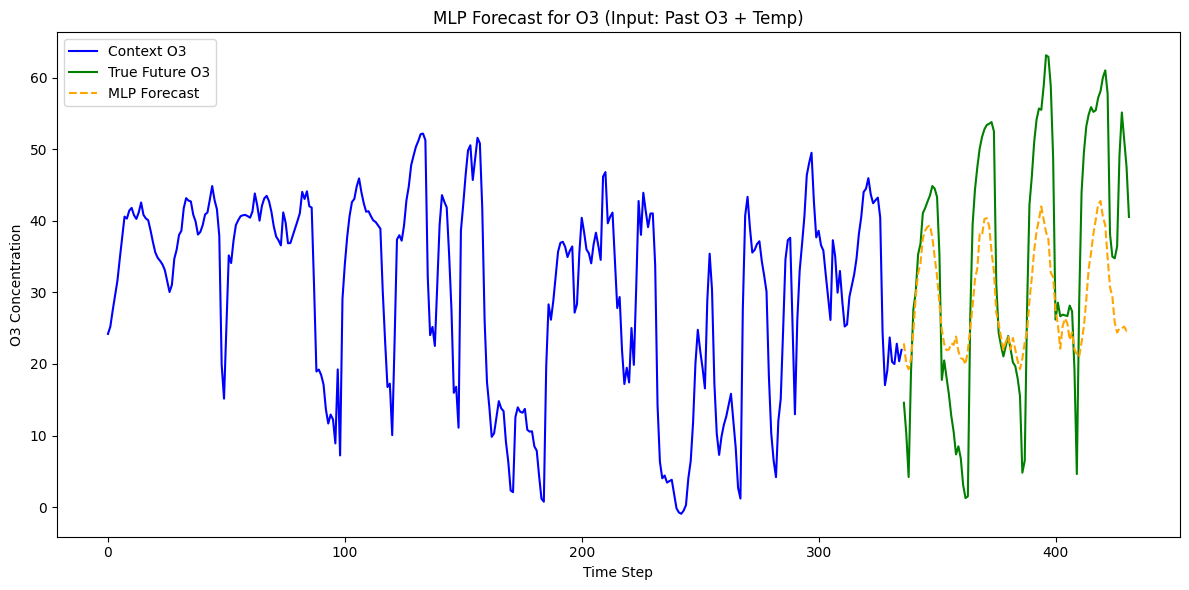

In [7]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from google.colab import drive

# mount Drive so we can read/save data
drive.mount("/content/drive")

# Settings for forecasting
context_window = 336              # how many past time steps the model sees
prediction_horizon = 96           # how many time steps forecast
model_id = "mlp_o3_on_o3_temp"    # to distinguish different setups later

# Define folders where models and forecasts will be stored
checkpoint_dir = "/content/drive/MyDrive/timeseries_datanew/mlp_checkpoints"
forecast_dir   = "/content/drive/MyDrive/timeseries_datanew/mlp_forecasts"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(forecast_dir, exist_ok=True)

# Load the multivariate dataset from Drive
with open("/content/drive/MyDrive/timeseries_datanew/X_train_multi.pkl", "rb") as f:
    X_train_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/X_test_multi.pkl", "rb") as f:
    X_test_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/y_train_multi.pkl", "rb") as f:
    y_train_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/y_test_multi.pkl", "rb") as f:
    y_test_full = pickle.load(f)

# Extract Temp and 03 (column 0 and 1)
X_train = X_train_full[:, :, :2]    # we use both variables (temp + o3)
X_test  = X_test_full[:, :, :2]
y_train = y_train_full[:, :, 1]     # again only o3 as output
y_test  = y_test_full[:, :, 1]

# flatten input for MLP
X_train_flat = X_train.reshape(X_train.shape[0], context_window * 2)     # 336*2 features
X_test_flat  = X_test.reshape(X_test.shape[0], context_window * 2)
y_train_flat = y_train.reshape(y_train.shape[0], prediction_horizon)     # output stays same

# define model (mlp)
mlp_model = Sequential([
    Input(shape=(context_window * 2,)),       #input shape (flat 336*2 steps)
    Dense(128, activation="relu"),            # first dense layer with 128 units
    Dense(64, activation="relu"),             # second dense layer with 64 units
    Dense(prediction_horizon)                 #output 96 future values
])

# Compile the model with mse-loss and ada-optimizer
mlp_model.compile(optimizer=Adam(), loss=MeanSquaredError())

# important so save best model each time when there is an improvement
checkpoint_path = os.path.join(checkpoint_dir, f"{model_id}.h5")
checkpoint_cb = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
)

# train model (if there is no checkpoint)
if os.path.exists(checkpoint_path):
    print("checkpoint")
    mlp_model = load_model(checkpoint_path, custom_objects={"mse": MeanSquaredError()})
else:
    history = mlp_model.fit(
        X_train_flat, y_train_flat,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        callbacks=[checkpoint_cb],
        verbose=1
    )

# use best model to make predictions
y_pred_flat = mlp_model.predict(X_test_flat, verbose=0)
y_pred = y_pred_flat.reshape(-1, prediction_horizon, 1)  # shape: (samples, 96, 1)

# calculate mse
mse = mean_squared_error(y_test.reshape(-1), y_pred.reshape(-1))
print(f"MSE TEST MLP: {mse:.3f}")

# save data to Drive
np.save(f"{forecast_dir}/X_context_{model_id}.npy", X_test)
np.save(f"{forecast_dir}/y_true_{model_id}.npy", y_test)
np.save(f"{forecast_dir}/forecast_{model_id}.npy", y_pred)

# Plot example forecast (index 0) from the test set
example_idx = 0
plt.figure(figsize=(12, 6))
plt.plot(range(context_window), X_test[example_idx, :, 1], label="Context O3", color="blue")
plt.plot(range(context_window, context_window + prediction_horizon), y_test[example_idx], label="True Future O3", color="green")
plt.plot(range(context_window, context_window + prediction_horizon), y_pred[example_idx, :, 0], label="MLP Forecast", color="orange", linestyle="--")
plt.title("MLP Forecast for O3 (Input: Past O3 + Temp)")
plt.xlabel("Time Step")
plt.ylabel("O3 Concentration")
plt.legend()
plt.tight_layout()
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
checkpoint


MSE TEST MLP (O3 ← past O3 + past Temp + future Temp): 85.429


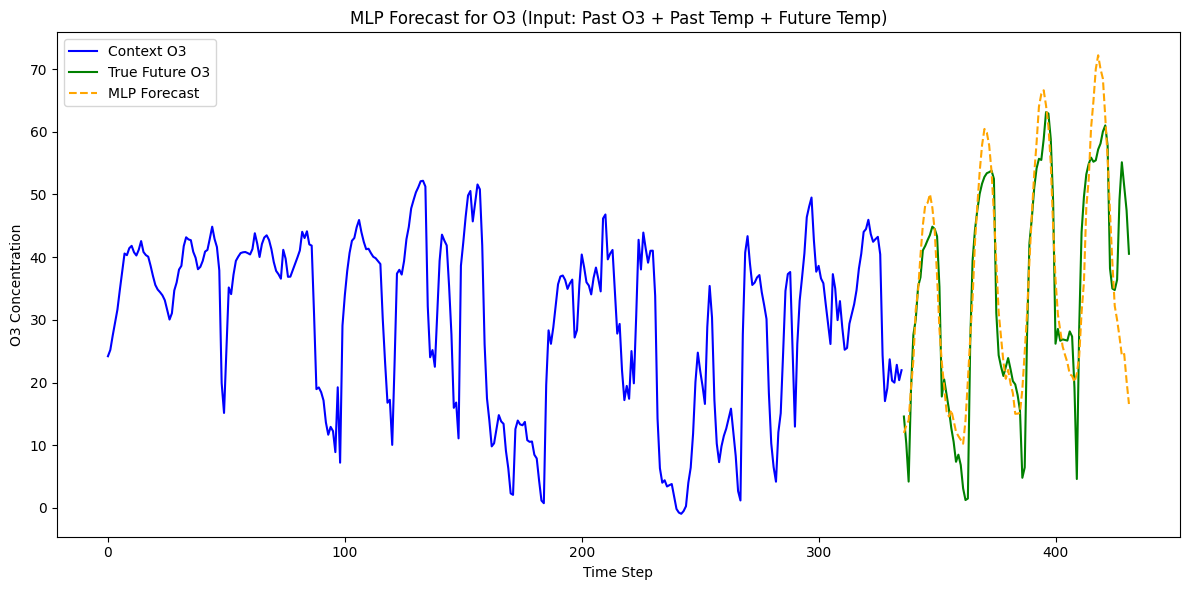

In [8]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from google.colab import drive

# mount Drive so we can read/save data
drive.mount("/content/drive")

# Settings for forecasting
context_window = 336                    # how many past time steps the model sees
prediction_horizon = 96                 # how many time steps forecast
model_id = "mlp_o3_on_o3_temp_future"   # to distinguish different setups later

# Define folders where models and forecasts will be stored
checkpoint_dir = "/content/drive/MyDrive/timeseries_datanew/mlp_checkpoints"
forecast_dir   = "/content/drive/MyDrive/timeseries_datanew/mlp_forecasts"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(forecast_dir, exist_ok=True)

# Load the multivariate dataset from Drive
with open("/content/drive/MyDrive/timeseries_datanew/X_train_multi.pkl", "rb") as f:
    X_train_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/X_test_multi.pkl", "rb") as f:
    X_test_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/y_train_multi.pkl", "rb") as f:
    y_train_full = pickle.load(f)
with open("/content/drive/MyDrive/timeseries_datanew/y_test_multi.pkl", "rb") as f:
    y_test_full = pickle.load(f)

# Extract just the needed columns (0 = temp, 1 = o3)
X_o3       = X_train_full[:, :, 1]
X_temp     = X_train_full[:, :, 0]
y_o3       = y_train_full[:, :, 1]     # we predict future o3
y_temp     = y_train_full[:, :, 0]     # future temperature

X_o3_test  = X_test_full[:, :, 1]
X_temp_test = X_test_full[:, :, 0]
y_o3_test  = y_test_full[:, :, 1]
y_temp_test = y_test_full[:, :, 0]

# combine past o3 and temp to one vector
X_train_combined = np.concatenate([X_o3, X_temp], axis=1)        # shape: (samples, 336*2)
X_test_combined  = np.concatenate([X_o3_test, X_temp_test], axis=1)

# flatten input
X_train_flat = X_train_combined.reshape(X_train_combined.shape[0], -1)
X_test_flat  = X_test_combined.reshape(X_test_combined.shape[0], -1)

# also flatten future temperature (exogenous input)
y_temp_flat     = y_temp.reshape(y_temp.shape[0], prediction_horizon)
y_temp_test_flat = y_temp_test.reshape(y_temp_test.shape[0], prediction_horizon)

# final input = past o3 + past temp + future temp
X_train_final = np.concatenate([X_train_flat, y_temp_flat], axis=1)
X_test_final  = np.concatenate([X_test_flat,  y_temp_test_flat], axis=1)

# flatten target (o3)
y_train_flat = y_o3.reshape(y_o3.shape[0], prediction_horizon)
y_test_flat  = y_o3_test.reshape(y_o3_test.shape[0], prediction_horizon)

# define model (mlp)
mlp_model = Sequential([
    Input(shape=(X_train_final.shape[1],)),      # input shape: flat combined vector
    Dense(128, activation="relu"),               # first dense layer
    Dense(64, activation="relu"),                # second dense layer
    Dense(prediction_horizon)                    # output: 96 future values
])

# Compile the model with mse-loss and ada-optimizer
mlp_model.compile(optimizer=Adam(), loss=MeanSquaredError())

# important so save best model each time when there is an improvement
checkpoint_path = os.path.join(checkpoint_dir, f"{model_id}.h5")
checkpoint_cb = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
)

# train model (if there is no checkpoint)
if os.path.exists(checkpoint_path):
    print("checkpoint")
    mlp_model = load_model(checkpoint_path, custom_objects={"mse": MeanSquaredError()})
else:
    history = mlp_model.fit(
        X_train_final, y_train_flat,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        callbacks=[checkpoint_cb],
        verbose=1
    )

# use best model to make predictions
y_pred_flat = mlp_model.predict(X_test_final, verbose=0)
y_pred = y_pred_flat.reshape(-1, prediction_horizon, 1)

# calculate mse
mse = mean_squared_error(y_test_flat.reshape(-1), y_pred.reshape(-1))
print(f"MSE TEST MLP (O3 ← past O3 + past Temp + future Temp): {mse:.3f}")

# save data to Drive
np.save(f"{forecast_dir}/X_context_{model_id}.npy", X_o3_test)
np.save(f"{forecast_dir}/y_true_{model_id}.npy", y_o3_test)
np.save(f"{forecast_dir}/forecast_{model_id}.npy", y_pred)

# plot forecast (index 0)
example_idx = 0
plt.figure(figsize=(12, 6))
plt.plot(range(context_window), X_o3_test[example_idx], label="Context O3", color="blue")
plt.plot(range(context_window, context_window + prediction_horizon), y_o3_test[example_idx], label="True Future O3", color="green")
plt.plot(range(context_window, context_window + prediction_horizon), y_pred[example_idx, :, 0], label="MLP Forecast", color="orange", linestyle="--")
plt.title("MLP Forecast for O3 (Input: Past O3 + Past Temp + Future Temp)")
plt.xlabel("Time Step")
plt.ylabel("O3 Concentration")
plt.legend()
plt.tight_layout()
plt.show()
